# Content

In this blog post we give a brief intorduction to the strip packing problem and its application. We will see for different variants of the problem the algebraic represenations as a MILP and pyomo implementions using the [GDP extension for generalized disjunctive programming](https://pyomo.readthedocs.io/en/stable/modeling_extensions/gdp/index.html).

In case that your are not familiar with disjunctive programming, let me briefly describe it as a framework to include logic or conditional contraints in an algebraic model. Typical applications of disjunctive programming are: ordering of tasks (e.g. in a production process), choosing optimal route in a circuit of organizing complex projects in a time saving manner. Typical techniques are refomulation as mixed interger program, Big-M reformulation and Hull reformulation.

## Problem description

The [strip packing problem](https://en.wikipedia.org/wiki/Strip_packing_problem) is a cutting and packing problem. In its basic form we want to pack rectangles on a two dimensional strip of fixed width and virtually infinite height. In other variants consider the different geometry of the packed objects, the dimension (e.g. backing of boxes in 3 dimensions) or the structure of the packing, e.g. [guillotine packing](https://en.wikipedia.org/wiki/Guillotine_cutting). The strip packing problem contains as a special case the [bin packing problem](https://en.wikipedia.org/wiki/Bin_packing_problem) and hence its NP-hard.

There exists various approximation methods, such as heuristics and metaheuristcs, to solve the two dimensional strip packing problem.

## Applications

The list of applications mainly steam from which inspired this blog https://mobook.github.io/MO-book/notebooks/03/strip-packing.html:

1. cutting out of a sheet of material with fixed width but "infinite length", e.g. paper or textitle cuts
2. placement of marco cells in semiconductor layouts
3. workstation layout in a manufacturing facility
4. scheduling allocations of a common resource.


My personal motivation was an optimized bed planning in the garden. But because its model containts additional modifications I wanted to blog first about one of its core problem.

In [ ]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 

## Example

We randomly generate data. Here each row represents a box of width $w$ and height $h$.

In [ ]:
# helper functions

## nb param
number_of_boxes = 5
shelf_depth = 1 # will be overwritten
np.random.seed(1111)

# data generation

def gen_box(number_of_boxes = number_of_boxes, wlow=1, whigh=100, hlow=1, hhigh=100):
    """generates random number_of_boxes data, where width of each box varies between wlow and whigh, and heigth within hlow and hheigth """
    return pd.DataFrame({
    'w': np.random.randint(wlow, whigh, size = number_of_boxes),
    'h': np.random.randint(hlow, hhigh, size = number_of_boxes),
    })


## data generation
boxes = gen_box()
data ={
    'data' : boxes,
    'solver' : 'cbc',
    'model_name': 'strip_packing',
    'shelf_depth' : 2 * boxes['h'].max()
}

shelf_depth = 2 * data['data']['h'].max()

In [ ]:
# inspect data
display(data['data'])

,w,h
0,29,53
1,56,25
2,82,23
3,13,21
4,35,12


In [ ]:
def _packing(df):
    """temp function to transform input data into a df like the solution for visualization"""
    dt = df.copy()
    dt['x1'] = dt['w'].cumsum() - dt['w']
    dt['x2'] = dt['w'].cumsum()
    dt['y1'] = 0
    dt['y2'] = dt['h']
    dt['r'] = 0
    return dt

def plot_solution(sol, shelf_depth = shelf_depth):
    """plot items bounding boxes"""
    
    fig, ax = plt.subplots()
    
    for i, x, y, w, h, r in zip(sol.index, sol['x1'], sol['y1'], sol['w'], sol['h'], sol['r']):
        color = 'g'
        # if box rotated then exchange heigth and width and use red as color
        if r:
            h, w = w, h
            color = 'r'
        ax.add_patch(Rectangle((x, y), w, h, 
                               edgecolor='k', facecolor=color, alpha=0.6))
        # place item name in the middle of each box
        ax.annotate(i, (x+w/2, y+h/2), color='w', weight='bold', fontsize=12, ha='center', va='center')
    
    # set axis limits
    ax.set_xlim(0, 1.1*sol["w"].sum())
    ax.set_ylim(0, shelf_depth*1.1)
    
    # draw line for total used width
    ax.axvline(sol["x2"].max(), ymin = 0, ymax = shelf_depth/ax.get_ylim()[1],
               label="shelf width $W$", color="r")
    ax.fill_between([0, ax.get_xlim()[1]], [shelf_depth, shelf_depth], color="c", alpha=0.2)
    ax.set_title('packing')
    ax.set_xlabel("width")
    ax.set_ylabel("heigth")
    

# Heuristic: First-in-first-out

An obivious solution to the strip packing problem is given by an first-in-first-out heuristic. Which would result in the following packing:

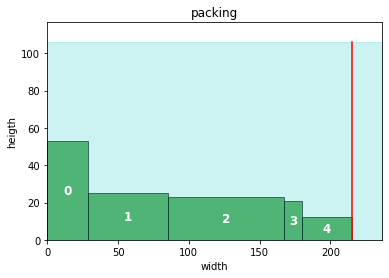

In [ ]:
# visualizse fifo packing with no rotation
sol = _packing(data['data'])
plot_solution(sol, shelf_depth = shelf_depth)

# "simple packing" - Model

Although this simple model is equivalent to a frist-in-first-out strategy and produces a solution everyone can come up with, its a good starting point because its a building block of more elaborated variants.

## algebraic model

### sets

- $I=\{1,\ldots,n\}$ set of boxes to be packed
- $order:=\{(i,j) | i,j\in I,\; i<j\}$ used to define the packing order

### param

- $w_i$ width of box i
- $h_i$ heigth of box i

### vars

- $W$ total used width
- $x1_i$ left x-coordinate of box i
- $x2_i$ right x-coordinate of box i
- $y1_i$ left y-coordinate of box i
- $y2_i$ right 1-coordinate of box i

### constraints

- box width: left x coordinate and right x coordinate of box i differ by width of box i, i.e. $x_{2,i}=x_{1,i}+w_i$
- no box is placed after total used width, i.e. $x_{2,i} \leq W$
- no overlap: either box i is placed before j or j before i, i.e. $x_{1,i} \leq x_{1,j}$ or $x_{1,j} \leq x_{1,i}$


### objective

- minimize total used width $W$

### model

$$
\begin{array}{lll}
\min & W & \\
s.t. & x_{i,2} \leq W & \forall i\\
     & x_{i,1},x_{i,2} \geq 0 & \forall i\\
     & y_{i,1} = 0 & \forall i\\
     & [x_{i,2}\leq x_{j,1}] \vee [x_{j,2} \leq x_{i,1}] & \forall i < j
\end{array}     
$$

### Remark

For the variants of the strip packing problem considered here its easy to give bounds on the descision variables as an upper bound on the shelf width. For simplicity we use:
$$
W_B:=\sum w_i
$$

## Pyomo implementation

In [ ]:
# pyomo implementation

def SP_simple(data):
    """simple strip packing, but useful to study good/new neighboor constraints later"""
    
    # simple upper bound
    w_bound = data['data']['w'].sum()
    
    # instanciate model
    m = pyo.ConcreteModel(data['model_name'])
    # sets
    m.I = pyo.Set(initialize = data['data'].index, doc = 'items')
    m.Order = pyo.Set(initialize = m.I * m.I, filter = lambda m,i,j: i<j)
    
    # vars
    m.x1 = pyo.Var(m.I, domain = pyo.NonNegativeReals, bounds = (0,w_bound))
    m.x2 = pyo.Var(m.I, domain = pyo.NonNegativeReals, bounds = (0,w_bound))
    m.W = pyo.Var(domain = pyo.NonNegativeReals, doc = 'total width, to be optimized')
    m.r = pyo.Var(domain = pyo.Boolean, initialize = False, doc = 'not used in no rotation model')
    
    # objective
    m.OBJ = pyo.Objective(expr = m.W, sense = pyo.minimize)
    
    # param
    @m.Param(m.I)
    def w(m,i):
        return data['data'].filter(items = [i], axis = 0)['w'].values[0]
    
    # constraints
    @m.Constraint(m.I, doc = 'determines box i size')
    def bounding_box(m,i):
        return m.x2[i] == m.x1[i] + m.w[i]
    
    @m.Constraint(m.I, doc = 'defines total width, to be optimized')
    def total_width(m,i):
        return m.x2[i] <= m.W
    
    @m.Disjunction(m.Order, xor=True)
    def no_overlap(m, i, j):
        return [m.x2[i] <= m.x1[j],
                m.x2[j] <= m.x1[i]]
       
    
    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    
    # choose solver and apply solver
    solver = pyo.SolverFactory(data['solver'])
    solver.solve(m)
    
    # extract solution
    sol = data['data'].copy()
    # extract coords from solution
    sol['x1'] = [pyo.value(m.x1[i]) for i in m.I]
    sol['x2'] = [pyo.value(m.x2[i]) for i in m.I]
    # placeholder
    sol['y1'] = [0 for i in m.I]
    sol['y2'] = sol['h']
    sol['r'] = [False for i in m.I]
        
    return sol

CPU times: user 104 ms, sys: 10.9 ms, total: 114 ms
Wall time: 481 ms


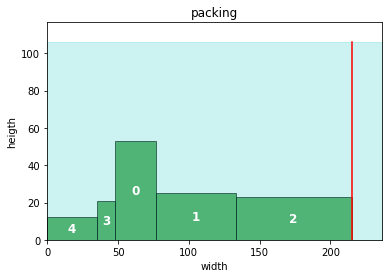

In [ ]:
%%time
sol = SP_simple(data)
# visualise sollution
plot_solution(sol)

# Add rotation to model

Obviously rotating certain boxes would result in a tighter packing. Therefore we add a boolean variable `r_i` which equals true iff the box was rotated.

## algebraic model with roation

$$
\begin{array}{lll}
\min & W & \\
s.t. & x_{i,2} \leq W & \forall i\\
     & x_{i,1},x_{i,2} \geq 0 & \forall i\\
     & y_{i,1} = 0 & \forall i\\
     & [x_{i,2}\leq x_{j,1}] \vee [x_{j,2} \leq x_{i,1}] & \forall i < j\\
     & \left[ \begin{array}{ll}
     r_i= & false\\
     x_{i,2} = & x_{i,1} + w_i\\
     y_{i,2} = & y_{i,1} + h_i
     \end{array} \right] \vee 
     \left[ \begin{array}{ll}
     r_i= & true\\
     x_{i,2} = & x_{i,1} + h_i\\
     y_{i,2} = & y_{i,1} + w_i
     \end{array}\right] & \forall i < j
\end{array}     
$$


## Pyomo implementation

In [ ]:
def SP_rot(data):
    """strip packing with rotation"""
    
    W_ub = data['data']['w'].sum()
    
    m = pyo.ConcreteModel()
    
    # sets
    m.I = pyo.Set(initialize = data['data'].index, doc = 'plants')
    m.Order = pyo.Set(initialize = m.I * m.I, filter = lambda m,i,j:i<j, doc ='ordering of plants')
    
    # vars
    m.W = pyo.Var(bounds = (0,W_ub), doc = 'total optimal width')
    m.x1 = pyo.Var(m.I, bounds = (0,W_ub), doc = 'LHS of item i on x axis')
    m.x2 = pyo.Var(m.I, bounds = (0,W_ub), doc = 'RHS of item i on x axis')
    m.y1 = pyo.Var(m.I, bounds = (0,W_ub), doc = 'LHS of item i on y axis')
    m.y2 = pyo.Var(m.I, bounds = (0,W_ub), doc = 'RHS of item i on y axis')
    m.r = pyo.Var(m.I, domain = pyo.Boolean)
    
    # objective
    @m.Objective()
    def minimal_width(m):
        return m.W
    
    # param
    @m.Param(m.I)
    def w(m,i):
        return data['data'].filter(items = [i], axis = 0)['w'].values[0]
    @m.Param(m.I)
    def h(m,i):
        return data['data'].filter(items = [i], axis = 0)['h'].values[0]
    
    # constraints
    @m.Constraint(m.I)
    def c1(m,i):
        return m.x2[i] <= m.W
    @m.Constraint(m.I)
    def y1_loc(m,i):
        return m.y1[i] == 0
    @m.Disjunction(m.I)
    def rotation(m,i):
        return [
            [m.r[i] == False, 
             m.x2[i] == m.x1[i] + m.w[i],
             m.y2[i] == m.y1[i] + m.h[i]
            ],
            [m.r[i] == True,
             m.x2[i] == m.x1[i] + m.h[i],
             m.y2[i] == m.y1[i] + m.w[i]
            ]
        ]
    @m.Disjunction(m.Order)
    def no_overlap(m,i,j):
        return [
            [m.x2[i] <= m.x1[j]],
            [m.x2[j] <= m.x1[i]]
        ]
    
    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    
    # choose solver and apply solver
    solver = pyo.SolverFactory(data['solver'])
    solver.solve(m)
    
    # extract solution
    sol = data['data'].copy()
    # extract coords from solution
    sol['x1'] = [pyo.value(m.x1[i]) for i in m.I]
    sol['x2'] = [pyo.value(m.x2[i]) for i in m.I]
    # placeholder
    sol['y1'] = [pyo.value(m.y1[i]) for i in m.I]
    sol['y2'] = [pyo.value(m.y2[i]) for i in m.I]
    sol['r'] = [pyo.value(m.r[i]) for i in m.I]
    
    return sol

In order to see when a rotation was applied we plot rotated boxes in red.

CPU times: user 99.2 ms, sys: 21 ms, total: 120 ms
Wall time: 561 ms


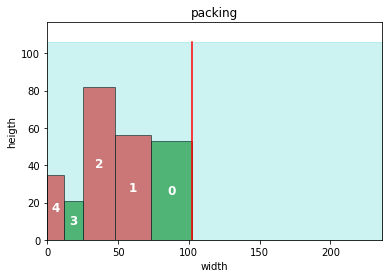

In [ ]:
%%time
sol_rot = SP_rot(data)
plot_solution(sol_rot)

# Packing in 2 dimensions with rotation

Again obviously we can reduce the required total width if we allow to pack boxes in 2 dimensions, e.g. we place a box behind another.

## algebraic model

### Additional constraints

- upper $y$ coordinate of box does not exceed shelf depth $D$
- no overlap of boxes in y-axis

### Model

$$
\begin{array}{lll}
\min & W & \\
s.t. & x_{i,2} \leq W & \forall i\\
     & y_{i,2} \leq D & \forall i\\
     & x_{i,1},x_{i,2}, y_{i,1}, y_{i,2} \geq 0 & \forall i\\
     & y_{i,1} = 0 & \forall i\\
     & [x_{i,2}\leq x_{j,1}] \vee 
       [x_{j,2} \leq x_{i,1}] \vee       
       [y_{i,2}\leq y_{j,1}] \vee 
       [y_{j,2} \leq y_{i,1}]
       & \forall i < j\\
     & \left[ \begin{array}{ll}
     r_i= & false\\
     x_{i,2} = & x_{i,1} + w_i\\
     y_{i,2} = & y_{i,1} + h_i
     \end{array} \right] \vee 
     \left[ \begin{array}{ll}
     r_i= & true\\
     x_{i,2} = & x_{i,1} + h_i\\
     y_{i,2} = & y_{i,1} + w_i
     \end{array}\right] & \forall i < j
\end{array}     
$$

## Pyomo implementation

In [ ]:
def SP_2dim_rot(data):
    """strip packing with rotation in 2 dimension"""
    
    W_ub = data['data']['w'].sum()
    
    m = pyo.ConcreteModel()
    
    # sets
    m.I = pyo.Set(initialize = data['data'].index, doc = 'plants')
    m.Order = pyo.Set(initialize = m.I * m.I, filter = lambda m,i,j:i<j, doc ='ordering of plants')
    
    # vars
    m.W = pyo.Var(bounds = (0,W_ub), doc = 'total optimal width')
    m.x1 = pyo.Var(m.I, bounds = (0,W_ub), doc = 'LHS of item i on x axis')
    m.x2 = pyo.Var(m.I, bounds = (0,W_ub), doc = 'RHS of item i on x axis')
    m.y1 = pyo.Var(m.I, bounds = (0,W_ub), doc = 'LHS of item i on y axis')
    m.y2 = pyo.Var(m.I, bounds = (0,W_ub), doc = 'RHS of item i on y axis')
    m.r = pyo.Var(m.I, domain = pyo.Boolean)
    
    # objective
    @m.Objective()
    def minimal_width(m):
        return m.W
    
    # param
    @m.Param(m.I)
    def w(m,i):
        return data['data'].filter(items = [i], axis = 0)['w'].values[0]
    @m.Param(m.I)
    def h(m,i):
        return data['data'].filter(items = [i], axis = 0)['h'].values[0]
    m.shelf_depth = pyo.Param(mutable = True,
                              initialize = data['shelf_depth'])
    
    # constraints
    @m.Constraint(m.I)
    def minimize_width(m,i):
        return m.x2[i] <= m.W
    @m.Constraint(m.I)
    def max_heigth(m,i):
        return m.y2[i] <= m.shelf_depth
    
    @m.Disjunction(m.I)
    def rotation(m,i):
        return [
            [m.r[i] == False, 
             m.x2[i] == m.x1[i] + m.w[i],
             m.y2[i] == m.y1[i] + m.h[i]
            ],
            [m.r[i] == True,
             m.x2[i] == m.x1[i] + m.h[i],
             m.y2[i] == m.y1[i] + m.w[i]
            ]
        ]
    @m.Disjunction(m.Order)
    def no_overlap(m,i,j):
        return [
            [m.x2[i] <= m.x1[j]],
            [m.x2[j] <= m.x1[i]],
            [m.y2[i] <= m.y1[j]],
            [m.y2[j] <= m.y1[i]]
        ]
    
    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    
    # choose solver and apply solver
    solver = pyo.SolverFactory(data['solver'])
    solver.solve(m)
    
    # extract solution
    sol = data['data'].copy()
    # extract coords from solution
    sol['x1'] = [pyo.value(m.x1[i]) for i in m.I]
    sol['x2'] = [pyo.value(m.x2[i]) for i in m.I]
    # placeholder
    sol['y1'] = [pyo.value(m.y1[i]) for i in m.I]
    sol['y2'] = [pyo.value(m.y2[i]) for i in m.I]
    sol['r'] = [pyo.value(m.r[i]) for i in m.I]
    
    return sol

CPU times: user 118 ms, sys: 47.6 ms, total: 166 ms
Wall time: 271 ms


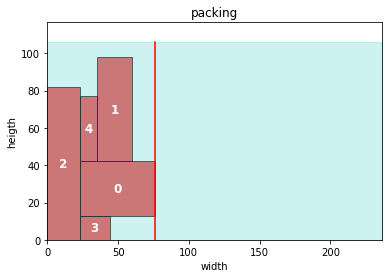

In [ ]:
%%time
sol_rot = SP_2dim_rot(data)
plot_solution(sol_rot)